In [104]:
%matplotlib inline

In [260]:
import os
import json
import operator
from sodapy import Socrata # socrata api tools
import pandas as pd
import numpy as np

In [286]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

# Data Gathering and Exploration
We will be using data from the Washington State open data portal, powered by Socrata. Specifically, we'll be taking a look at expenditures by candidates and political committees over the last 10 years. The dataset can be found online here:

https://data.wa.gov/Politics/Expenditures-by-Candidates-and-Political-Committee/tijg-9zyp

## Connect to the data source
Socrata provides several options for getting data. While we can download the data as a .csv file, I'm choosing to pull the data via their API. That way whenever I choose to re-run the notebook I can get the most up-to-date version of the data possible. Socrata provides excellent documentation for their API on all their datasets. The API reference for this dataset can be found here:

https://dev.socrata.com/foundry/data.wa.gov/ukxb-bc7h

In [54]:
portal_url = "data.wa.gov"
resource = "ukxb-bc7h"
refresh_data = False

In [232]:
# retrieve my app token
with open('secrets.json') as f:
    data = json.load(f)
    app_token = data['app_token']

In [233]:
# Establish connection to the client, retrieve one item for testing
client = Socrata(portal_url, app_token)
client.get(resource, limit=1)

[{'amount': '0.00',
  'election_year': '2016',
  'expenditure_date': '2016-10-18T00:00:00.000',
  'filer_id': 'VALDR  074',
  'filer_name': 'VALDERRAMA RAMIRO M',
  'first_name': 'RAMIRO',
  'id': '1102801.expn',
  'itemized_or_non_itemized': 'Non-itemized',
  'jurisdiction': 'LEG DISTRICT 45 - HOUSE',
  'jurisdiction_county': 'KING',
  'jurisdiction_type': 'Legislative',
  'last_name': 'VALDERRAMA',
  'legislative_district': '45',
  'middle_initial': 'M',
  'office': 'STATE REPRESENTATIVE',
  'origin': 'A/LE50',
  'party': 'REPUBLICAN',
  'position': '01',
  'recipient_name': 'EXPENSES OF $50 OR LESS',
  'report_number': '100733345',
  'type': 'Candidate',
  'url': 'http://web.pdc.wa.gov/rptimg/default.aspx?batchnumber=100733345',
  'url_description': 'View report'}]

### Success! 
Looks like we can connect to the API and pull data. There are about 700k rows in the dataset, so we will page through the results and store them in a list which we will concatenate at the end into a dataframe.

In [56]:
if (not os.path.isfile('spending_dollars.pkl')) or refresh_data:
    limit = 50000
    offset = 0
    frames = []
    while 1:
        result = client.get(resource, limit=limit, offset=offset)
        if len(result) == 0:
            break
        frames.append(pd.DataFrame.from_records(result))
        print(f"Page {int((offset/limit)+1)} loaded with {len(result)} rows")

        offset = offset + limit
    df = pd.concat(frames, ignore_index = True)
else:
    df = pd.read_pickle('spending_dollars.pkl')

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698878 entries, 0 to 698877
Data columns (total 32 columns):
amount                      698878 non-null float64
ballot_number               698878 non-null object
code                        698878 non-null object
description                 698878 non-null object
election_year               698878 non-null int64
expenditure_date            698553 non-null datetime64[ns]
filer_id                    698878 non-null object
filer_name                  698878 non-null object
first_name                  698878 non-null object
for_or_against              698878 non-null object
id                          698878 non-null object
itemized_or_non_itemized    698878 non-null object
jurisdiction                698878 non-null object
jurisdiction_county         698878 non-null object
jurisdiction_type           698878 non-null object
last_name                   698878 non-null object
legislative_district        698878 non-null object
middle_initial

### Data Cleaning
Looking at the info, there are a couple of columns that we would expect to be numeric. There are also a lot of NULL values for some of the string columns. Instead of leaving these as nan, we'll replace them with a string representation.

In [84]:
# string fill NaN first
df.fillna('NAN', inplace=True)

# then cast `amount` and `election_year` to numeric
df = df.astype({'amount': float, 'election_year': int})

# convert `expenditure_date` to datetime
df['expenditure_date'] = pd.to_datetime(df['expenditure_date'])

# save the output so we don't have to download each time
df.to_pickle('spending_dollars.pkl')

In [28]:
df.columns

Index(['amount', 'ballot_number', 'code', 'description', 'election_year',
       'expenditure_date', 'filer_id', 'filer_name', 'first_name',
       'for_or_against', 'id', 'itemized_or_non_itemized', 'jurisdiction',
       'jurisdiction_county', 'jurisdiction_type', 'last_name',
       'legislative_district', 'middle_initial', 'office', 'origin', 'party',
       'position', 'recipient_address', 'recipient_city', 'recipient_location',
       'recipient_name', 'recipient_state', 'recipient_zip', 'report_number',
       'type', 'url', 'url_description'],
      dtype='object')

## Data Exploration

In this next bit, we'll spend some time exploring the data.

What are the most recent records in the dataset? Is this dataset really up-to-date?

In [129]:
df.sort_values('expenditure_date', ascending=False).head(5).T

,443249,443073,443253,443091,443072
amount,50,586,50,429.8,197
ballot_number,NAN,NAN,NAN,NAN,NAN
code,NAN,Independent Expenditures,NAN,Independent Expenditures,Independent Expenditures
description,INTERNET ADD,SUNDAY 11/4 YAKIMA HERALD REPRINT AD,INTERNET ADDS,BLUE WAVE AD YAKIMA HERALD,EL SOL AD
election_year,2018,2018,2018,2018,2018
expenditure_date,2018-11-05 00:00:00,2018-11-02 00:00:00,2018-11-02 00:00:00,2018-11-02 00:00:00,2018-11-01 00:00:00
filer_id,IAFFLS 383,HALLE 672,IAFFLS 383,HALLE 672,HALLE 672
filer_name,IAFF L2819 FOR A SAFER KITSAP,HALLOCK ELIZABETH A,IAFF L2819 FOR A SAFER KITSAP,HALLOCK ELIZABETH A,HALLOCK ELIZABETH A
first_name,NAN,ELIZABETH,NAN,ELIZABETH,ELIZABETH
for_or_against,For,NAN,For,NAN,NAN


In [60]:
df['type'].unique()

array(['Candidate', 'Political Committee'], dtype=object)

In [128]:
df['office'].unique()

array(['STATE REPRESENTATIVE', 'NAN', 'COUNTY PROSECUTOR',
       'STATE SENATOR', 'MAYOR', 'COUNTY COUNCIL MEMBER',
       'COUNTY COMMISSIONER', 'SUPERIOR COURT JUDGE',
       'CITY COUNCIL MEMBER', 'PUBLIC UTILITY COMMISSIONER',
       'SUPERINTENDENT OF PUBLIC INSTRUCTION', 'DISTRICT COURT JUDGE',
       'HOSPITAL COMMISSIONER', 'PUBLIC LANDS COMMISSIONER', 'GOVERNOR',
       'SECRETARY OF STATE', 'CHARTER REVIEW COMMISSIONER',
       'COUNTY EXECUTIVE', 'PORT COMMISSIONER', 'CITY ATTORNEY',
       'ATTORNEY GENERAL', 'COUNTY CLERK', 'STATE SUPREME COURT JUSTICE',
       'STATE AUDITOR', 'INSURANCE COMMISSIONER', 'SCHOOL DIRECTOR',
       'COUNTY SHERIFF', 'COUNTY AUDITOR', 'LIEUTENANT GOVERNOR',
       'COUNTY ASSESSOR', 'MUNICIPAL COURT JUDGE', 'FIRE COMMISSIONER',
       'STATE TREASURER', 'APPEALS COURT JUDGE', 'COUNTY TREASURER',
       'COUNTY DIR OF COMM DEV', 'CITY COUNCIL PRESIDENT',
       'COUNTY DIR OF ELECTIONS', 'WATER COMMISSIONER',
       'SEWER COMMISSIONER', 'COUN

In [248]:
df['code'].unique()

array(['NAN', 'Operation and Overhead', 'Contributions',
       'Independent Expenditures', 'Literature', 'Management Services',
       'Other Advertising', 'Wages and Salaries', 'Travel',
       'Broadcast Advertising', 'Postage', 'Fundraising',
       'Printed Advertising', 'Surveys and Polls', 'Signature Gathering'],
      dtype=object)

### General Spending
Let's take a cursory look at spending. We'll group by party and election year and view the sum. Sure are a lot of dollars in the "NAN" category...

In [127]:
# Spending by Party by Year
df.groupby(['party', 'election_year'])['amount'].sum().sort_values().unstack().T.sort_index()

party,CONSTITUTION PARTY,DEMOCRAT,INDEPENDENT,LIBERTARIAN,NAN,NON PARTISAN,NONE,OTHER,REPUBLICAN
election_year,,,,,,,,,
2008,NaN,43108312.41,78952.17,NaN,1.107321e+08,6163475.47,61237.54,251206.73,38444501.79
2009,NaN,648778.89,NaN,NaN,3.367829e+07,21576486.50,NaN,NaN,1115181.45
2010,NaN,12083974.86,NaN,NaN,6.744425e+07,2711311.44,103976.41,89136.89,10430655.31
2011,NaN,359417.05,NaN,NaN,5.075412e+07,7835032.50,NaN,NaN,497636.19
2012,8780.83,31692849.73,57158.24,NaN,8.281633e+07,4140476.41,31910.02,427783.96,23900441.01
2013,NaN,1010106.87,7235.76,NaN,7.193023e+07,13870097.77,NaN,NaN,1992801.42
2014,NaN,13696459.80,107339.81,17842.86,6.928116e+07,2860994.28,140712.12,516942.08,12981898.72
2015,NaN,635682.15,NaN,NaN,1.686796e+07,6254545.28,NaN,NaN,794323.53
2016,NaN,21342321.94,2800.70,28254.00,7.114132e+07,3098937.80,134863.43,1799933.02,14631607.95


How about looking at the spending again, this time just for the Political Committees? Is there partisan spend for the PAC categories, or do those not have a political affiliation?

In [87]:
# Spending by Party by Year for Political Committees
df[df.type == 'Political Committee'].groupby(['party', 'election_year'])['amount'].sum().sort_values().unstack().T.sort_index()

party,NAN,NON PARTISAN,REPUBLICAN
election_year,,,
2008,1.107321e+08,NaN,NaN
2009,3.367829e+07,NaN,NaN
2010,6.744425e+07,NaN,NaN
2011,5.075412e+07,NaN,NaN
2012,8.281633e+07,NaN,NaN
2013,7.193001e+07,NaN,NaN
2014,6.928116e+07,NaN,NaN
2015,1.686796e+07,NaN,NaN
2016,7.114132e+07,NaN,NaN


This is a curiosity... there is a very small dollar amount for Republican political committee spending. What is it?

In [238]:
df[(df.type == 'Political Committee') & (df.party == 'REPUBLICAN')]

,amount,ballot_number,code,description,election_year,expenditure_date,filer_id,filer_name,first_name,for_or_against,...,recipient_address,recipient_city,recipient_location,recipient_name,recipient_state,recipient_zip,report_number,type,url,url_description
350822,67.47,NAN,NAN,ORDERED CHECKS,2018,2018-03-27,28THDR 467,28TH DIST REPUB LEG COMM NON EXEMPT,NAN,NAN,...,15955 LA CANTERA PARKWAY,SAN ANTONIO,"{'type': 'Point', 'coordinates': [-98.620006, ...",HARLAND CLARKE CHECK ORDER,TX,78256,100835820,Political Committee,http://web.pdc.wa.gov/rptimg/default.aspx?batc...,View report
350966,0.00,NAN,NAN,NAN,2018,2018-03-01,28THDR 467,28TH DIST REPUB LEG COMM NON EXEMPT,NAN,NAN,...,NAN,NAN,NAN,EXPENSES OF $50 OR LESS,NAN,NAN,100835820,Political Committee,http://web.pdc.wa.gov/rptimg/default.aspx?batc...,View report
361182,0.00,NAN,NAN,NAN,2018,2018-06-01,28THDR 467,28TH DIST REPUB LEG COMM NON EXEMPT,NAN,NAN,...,NAN,NAN,NAN,EXPENSES OF $50 OR LESS,NAN,NAN,100844391,Political Committee,http://web.pdc.wa.gov/rptimg/default.aspx?batc...,View report
391535,0.00,NAN,NAN,NAN,2018,2018-07-31,28THDR 467,28TH DIST REPUB LEG COMM NON EXEMPT,NAN,NAN,...,NAN,NAN,NAN,EXPENSES OF $50 OR LESS,NAN,NAN,100855545,Political Committee,http://web.pdc.wa.gov/rptimg/default.aspx?batc...,View report
414755,67.47,NAN,NAN,ORDERED CHECKS,2018,2018-03-27,28THDR 467,28TH DIST REPUB LEG COMM NON EXEMPT,NAN,NAN,...,15955 LA CANTERA PARKWAY,SAN ANTONIO,"{'type': 'Point', 'coordinates': [-98.620006, ...",HARLAND CLARKE CHECK ORDER,TX,78256,100835820,Political Committee,http://web.pdc.wa.gov/rptimg/default.aspx?batc...,View report
414898,0.00,NAN,NAN,NAN,2018,2018-03-01,28THDR 467,28TH DIST REPUB LEG COMM NON EXEMPT,NAN,NAN,...,NAN,NAN,NAN,EXPENSES OF $50 OR LESS,NAN,NAN,100835820,Political Committee,http://web.pdc.wa.gov/rptimg/default.aspx?batc...,View report
444161,0.00,NAN,NAN,NAN,2018,2018-07-31,28THDR 467,28TH DIST REPUB LEG COMM NON EXEMPT,NAN,NAN,...,NAN,NAN,NAN,EXPENSES OF $50 OR LESS,NAN,NAN,100855545,Political Committee,http://web.pdc.wa.gov/rptimg/default.aspx?batc...,View report


### For or Against?
I really dislike watching attack ads. What about this `for_or_against` column? Where makes up this info - from candidates or committees?

In [91]:
df.groupby(['type', 'for_or_against'])['amount'].count().unstack()

for_or_against,Against,For,NAN
type,,,
Candidate,NaN,NaN,397897.0
Political Committee,8906.0,45077.0,246998.0


What is the breakdown by spending code?

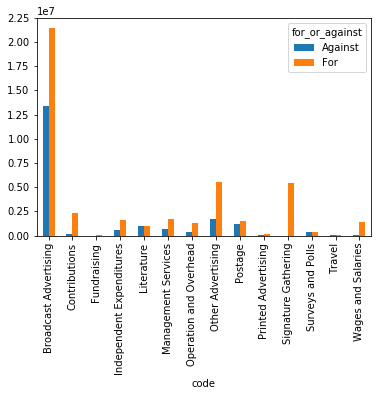

In [247]:
df[(df.type == 'Political Committee') & 
   (df.for_or_against != 'NAN') & 
   (df.code != 'NAN')
].groupby(['code', 'for_or_against'])['amount'].sum().unstack().plot(kind='bar')

What do the dollar amounts look like?

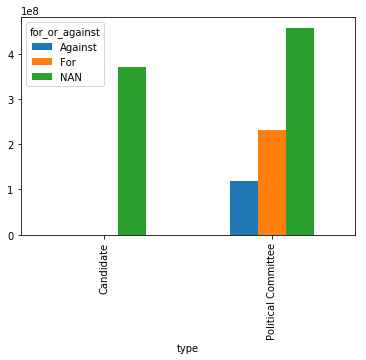

In [121]:
df.groupby(['type', 'for_or_against'])['amount'].sum().unstack().plot(kind='bar')

### Expenditure over time

What pattern does expenditure follow? Has it increased in recent years, or stayed the same?

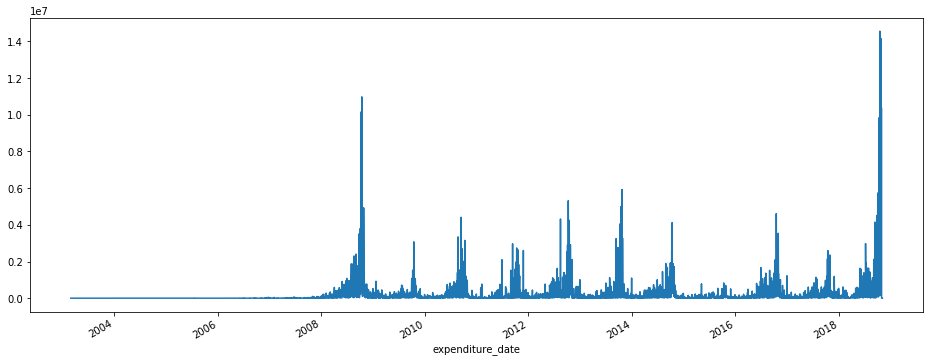

In [108]:
df.groupby('expenditure_date')['amount'].sum().plot(figsize=(16, 6))

#### 2018 election year

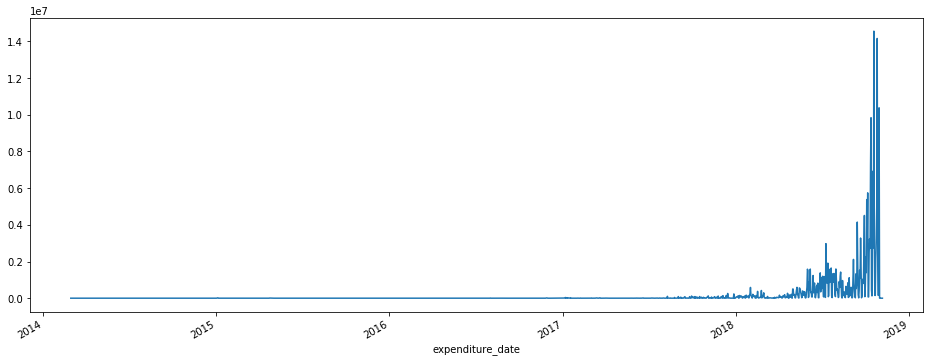

In [111]:
df[df.election_year == 2018].groupby('expenditure_date')['amount'].sum().plot(figsize=(16, 6))

In [113]:
df[df.election_year == 2018].sort_values('expenditure_date').head(5).T

,244851,305673,244125,304953,244514
amount,0,0,50,50,217.2
ballot_number,NAN,NAN,NAN,NAN,NAN
code,NAN,NAN,NAN,NAN,NAN
description,NAN,NAN,PAYMENT FOR SIGN STORAGE,PAYMENT FOR SIGN STORAGE,PHONE LIST
election_year,2018,2018,2018,2018,2018
expenditure_date,2014-03-01 00:00:00,2014-03-01 00:00:00,2014-03-03 00:00:00,2014-03-03 00:00:00,2014-03-12 00:00:00
filer_id,VOICTE 038,VOICTE 038,VOICTE 038,VOICTE 038,VOICTE 038
filer_name,VOICE OF TAHOMA EDUCATION,VOICE OF TAHOMA EDUCATION,VOICE OF TAHOMA EDUCATION,VOICE OF TAHOMA EDUCATION,VOICE OF TAHOMA EDUCATION
first_name,NAN,NAN,NAN,NAN,NAN
for_or_against,For,For,For,For,For


### Candidate Spending

Total amount of spend per candidate

In [123]:
df[df.type == 'Candidate'].groupby('filer_name')['amount'].sum().sort_values(ascending=False).head(10)

filer_name
INSLEE JAY R             21567420.78
GREGOIRE CHRISTINE O     19643892.29
ROSSI DINO J             19431941.96
MCKENNA ROBERT M         13364847.83
CONSTANTINE JAMES DOW     4949075.70
DHINGRA MANKA             3183955.16
ENGLUND JINYOUNG          2772272.44
FERGUSON ROBERT W         2666673.72
BRYANT WILLIAM L          2377255.32
ANGEL JANICE E            2152326.54
Name: amount, dtype: float64

Spend per candidate, by election year

In [131]:
df[df.type == 'Candidate'].groupby(['filer_name', 'election_year', 'office'])['amount'].sum().sort_values(ascending=False).head(20)

filer_name             election_year  office                   
ROSSI DINO J           2008           GOVERNOR                     19431941.96
GREGOIRE CHRISTINE O   2008           GOVERNOR                     19242486.66
INSLEE JAY R           2012           GOVERNOR                     13066617.59
MCKENNA ROBERT M       2012           GOVERNOR                     10271980.30
INSLEE JAY R           2016           GOVERNOR                      7612626.42
DHINGRA MANKA          2017           STATE SENATOR                 2961377.49
ENGLUND JINYOUNG       2017           STATE SENATOR                 2772272.44
MCKENNA ROBERT M       2008           ATTORNEY GENERAL              2231761.24
CONSTANTINE JAMES DOW  2009           COUNTY EXECUTIVE              2055912.95
BRYANT WILLIAM L       2016           GOVERNOR                      1943185.96
GOLDMARK PETER J       2008           PUBLIC LANDS COMMISSIONER     1831735.45
FERGUSON ROBERT W      2012           ATTORNEY GENERAL             

## Narrowing down the question

We've taken a look at the data in a number of different ways so far, and there are many other ways to slice and dice this data. We want to take the next step however, and see if there's something we can predict using the datset.

To me the spending by filer, election year, type and code is an interesting thing to look at. When we create this view, we have a single row for every candidate or political committee who filed an expenditure in a particular election year. What if we were to take the metadata out of this, and try and predict whether an entity is a political committee or a candidate based on their spend allocation during a particular election year?

In [264]:
data = df.groupby(['filer_name', 'election_year', 'type', 'code'])['amount'].sum().unstack('code').reset_index()
data.head()

code,filer_name,election_year,type,Broadcast Advertising,Contributions,Fundraising,Independent Expenditures,Literature,Management Services,NAN,Operation and Overhead,Other Advertising,Postage,Printed Advertising,Signature Gathering,Surveys and Polls,Travel,Wages and Salaries
0,$12 FOR TACOMA,2015,Political Committee,62148.0,NaN,NaN,NaN,NaN,NaN,106405.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10TH DIST DEMO NON EXEMPT,2008,Political Committee,NaN,NaN,NaN,1097.78,NaN,NaN,74192.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10TH DIST DEMO NON EXEMPT,2009,Political Committee,NaN,NaN,NaN,NaN,NaN,NaN,1493.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10TH DIST DEMO NON EXEMPT,2011,Political Committee,NaN,NaN,NaN,280.00,NaN,NaN,2051.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10TH DIST DEMO NON EXEMPT,2012,Political Committee,NaN,NaN,NaN,403.00,NaN,NaN,17411.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Define the Target
We will be using the `type` column as our target variable. We can transform it into a categorical variable that scikit-learn can handle.

In [265]:
target = data['type'].astype('category')
target.value_counts()

Political Committee    5521
Candidate              5367
Name: type, dtype: int64

### Define the Features
For the features we will use everything but the type, filer name, and the election year. We will also fill any NaN values with zeros.

In [266]:
features = data.drop(labels=['type', 'filer_name', 'election_year'], axis=1)
features = features.fillna(0)

### Set up the data and build a model
Let's split up the data by shuffling the dataframe and using 80% of the data to train our model.

In [280]:
# train/test split
train_test_args = dict(train_size = .8, test_size = .2, shuffle = True, random_state = 42)

features_train, features_test, target_train, target_test = train_test_split(features, target, **train_test_args)

Just to kick things off we will build a random forest classifier and train it on the data. This will be our baseline for now.

In [268]:
rf = RandomForestClassifier(n_estimators = 5000, n_jobs=-1, random_state=42)
rf.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [269]:
# results = pd.DataFrame({'predictions': rf.predict(features_test), 'actual': target_test})
# data.iloc[results[results['predictions'] != results['actual']].index].head()

In [270]:
rf.score(features_test, target_test)

0.6813590449954087

### First Model Results
Looks like our first model gave us an average accuracy of around 68.1%. Not stellar, but still better than flipping a coin. One idea is to not use the dollar amounts directly, but the percentage of spend inside each of the categories. We can create that dataset and fit another model.

In [271]:
featuresPCT = features.divide(features.sum(axis=1), axis='rows').fillna(0)

In [281]:
features_train, features_test, target_train, target_test = train_test_split(featuresPCT, target, **train_test_args)
rf_pct = RandomForestClassifier(n_estimators = 5000, n_jobs=-1, random_state=42)
rf_pct.fit(features_train, target_train)
rf_pct.score(features_test, target_test)

0.6845730027548209

Let's try a few different classifiers!

In [284]:
classifiers = {
    #'RandomForest': RandomForestClassifier(n_estimators = 5000, n_jobs=-1),
    'LogisticRegression': LogisticRegressionCV(cv=10, max_iter=1000, solver='liblinear'),
    'AdaBoostClassifier': AdaBoostClassifier(n_estimators=2000, learning_rate=.25),
    'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=2000)
}

In [285]:
perf = {}
for name, model in classifiers.items():
    model.fit(features_train, target_train)
    score = model.score(features_test, target_test)
    print(f'{name}: {score:.4%}')
    perf[name] = score

LogisticRegression: 62.2130%
AdaBoostClassifier: 70.7071%
GradientBoostingClassifier: 69.2378%


In [275]:
best_model_name = max(perf.items(), key=operator.itemgetter(1))[0]
print(f"The Best Model is ... {best_model_name}")

best = classifiers[best_model_name]

The Best Model is ... AdaBoostClassifier


In [276]:
target_test.value_counts()

Political Committee    1120
Candidate              1058
Name: type, dtype: int64

In [277]:
target_test[target_test == best.predict(features_test)].value_counts()

Political Committee    867
Candidate              691
Name: type, dtype: int64

In [278]:
tn, fp, fn, tp = confusion_matrix(target_test, best.predict(features_test)).ravel()
print(f"""Confusion Matrix:
True PAC: {tp}
True Candidate: {tn}
False PAC: {fp}
False Candidate: {fn}""")

Confusion Matrix:
True PAC: 867
True Candidate: 691
False PAC: 367
False Candidate: 253


In [ ]:
joblib.dump(best, 'best')